In [1]:
using CairoMakie
using Printf
using JLD2
using FourierFlows
include("AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
function linear_array_index(x, x_min, x_max, Nbins)
    return max(min(floor(Int, (x-x_min)/(x_max - x_min) * Nbins)+1, Nbins), 1)
end

function exponential_array_index(x, x_min, x_max, Nbins)
    return min(floor(Int, log(x/x_min) / log(x_max / x_min) * Nbins)+1, Nbins)
end

function count_bins(x, index_function, bin_counts)
    bin_idx = index_function.(x)
    @views bin_counts[bin_idx] .+= 1
    return bin_counts
end

function snapshot_counts(directory, dissipation_threshold, transform_function, Nbins, index_function, snap_idx)
    t, x, k, u = load_snapshot(directory, snap_idx)
    bin_counts = zeros(Nbins)
    ω = transform_function(k)
    return count_bins(ω[ω .<= dissipation_threshold], index_function, bin_counts), t
end

function timewise_counts(directory, Npackets, dissipation_threshold, transform_function, Nbins, index_function, idx_limit)
    have_been_dissipated = falses(Npackets)
    latest_t = 0
    bin_counts = zeros(Nbins)
    total_snapshots = 0
    filename_func(idx) = @sprintf("%s/packets.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("packets.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        for snapshot=keys(file["p/t"])
            if(total_snapshots >= idx_limit)
                break
            end
            latest_t =  file["p/t/" * snapshot]
            k =  file["p/k/" * snapshot]
            ω = transform_function(k)
            have_been_dissipated .|= (ω .>= dissipation_threshold)

            bin_idx = index_function.(ω[.~have_been_dissipated])
            @views bin_counts[bin_idx] .+= 1#exp(-1e-3 * latest_t)
            total_snapshots += 1
        end
        close(file)
    end
    return bin_counts, total_snapshots, latest_t, have_been_dissipated
end

timewise_counts (generic function with 1 method)

In [3]:
using SpecialFunctions: erfc

function ω2k(ω, f0, Cg)
    return @. sqrt(ω^2 - f0^2)/Cg
end

function theoretical_action_spectrum(k, k0, kmax, b, t, f0, Cg)
    source_term = @. exp(-log(k/k0)^2/(4*b*t))
    diss_term = @. exp(-log(k*k0/kmax^2)^2/(4*b*t))
    action_spectrum = @. 1/sqrt(4π*b*t)*exp(-b*t) * (source_term - diss_term)
end

function g(k, t)
    return @. erfc((2*t-log(k))/(2*sqrt(t)))
end

function theoretical_forced_action_spectrum(k, k0, kmax, b, t, f0, Cg)
    term1 = @. k^2  * k0^2   * g(kmax^2/k/k0, 2*b*t)
    term2 = @.        kmax^4 * g(k*k0/kmax^2, 2*b*t)
    term3 = @. k^2  * kmax^2 * g(k0/k, 2*b*t)
    term4 = @. k0^2 * kmax^2 * g(k/k0, 2*b*t)
    return (term1 + term2 - term3 - term4)./(4*b*k*k0*kmax^2)
end

theoretical_forced_action_spectrum (generic function with 1 method)

In [7]:
run_idx = 7
#data_directory = "/scratch/nad9961/swqg/58628043/"# Long run with 16x as many packets
#data_directory = "/scratch/nad9961/swqg_rays/58489830/"
#data_directory = "/scratch/nad9961/swqg/58031124/" # Long run at low Froude number, yeah this is way too low
#data_directory = "/scratch/nad9961/swqg/58025661/" # Long run with no cutoff wavenumber
#data_directory = "/scratch/nad9961/twolayer_rays/59310910/" # Two Layer Phillips instability
#data_directory = "/scratch/nad9961/swqg/59389740/" # One Layer run with maybe longer time and a bug fix (Use run_idx = 7) (*)
#data_directory = "/scratch/nad9961/swqg/57478238/"
#data_directory = "/scratch/nad9961/swqg/57233897/" # Matches RSW run 57233890
#data_directory = "/scratch/nad9961/swqg/58025661/" # This matches the energetics of the two layer flow hopefully (Use run_idx = 20)
data_directory = "/scratch/nad9961/swqg/60030992/" # This is a stronger background flow than case (*) (Use run_idx = 7)

run_directory = data_directory* string(run_idx)
Nsnapshots = count_snapshots(run_directory)
f0, Cg = read_parameters(run_directory)

radial_transform_function(k) = sqrt.(sum(k.^2, dims=2))
dispersion_transform_function(k) = compute_ω(k, f0, Cg)

t, _, k, _ = initial_packets = load_snapshot(run_directory, 1)
Npackets = size(k,1)
println(Npackets)

ω_min = f0
k_min = 0.1
k0 = 3
ω_max = 3000*f0

K_D = f0/Cg
k_max = 3000 * K_D

Nbins = 5000
#bin_edges = @. exp(log(ω_min) + (log(ω_max/ω_min)*(0:(Nbins-1))/(Nbins-1)))
#bin_size = diff(exp.((0:(Nbins))/Nbins * log(ω_max / ω_min) ) * ω_min)
#index_function(ω) = exponential_array_index(ω, ω_min, ω_max, Nbins)

bin_edges = @. k_min .+ (k_max - k_min) * (0:Nbins)/Nbins
bin_size = 1/Nbins
bin_centers = bin_edges[1:end-1] .+ 0.5*bin_size
index_function(x) = linear_array_index(x, k_min, k_max, Nbins)

max_snap_idx = floor(Int, Nsnapshots)
#forced_bin_counts, total_snapshots, latest_t, have_been_dissipated = timewise_counts(run_directory, Npackets, ω_max, dispersion_transform_function, Nbins, index_function, max_snap_idx)
bin_counts, time = snapshot_counts(run_directory, ω_max, dispersion_transform_function, Nbins, index_function, max_snap_idx)

16384


([340.0, 918.0, 688.0, 601.0, 532.0, 445.0, 395.0, 363.0, 297.0, 259.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 8214.853f0)

In [ ]:
using LsqFit

function find_best_b_fit(x, y, model, p0)
    fit = curve_fit(model, x, y, p0)
    return fit
end

function theo_free_decay_spectrum(k, p)
    τ = exp(p[2])
    result = exp.(-log.(k/k0).^2/(4*τ))
    result /= sum(result)
    #println(log.(result))
    return log.(result)
end

best_fit_func(k, p) = log.(p[1]*theoretical_action_spectrum(k, k0, k_max, max(p[2], 1e-19), 1, f0, Cg))

norm_bin_counts = nothing
nan_filter = nothing
fit = nothing
#N_snaps_skips = 400
times = zeros(max_snap_idx)
tau_params = zeros(max_snap_idx)
array_idx = 1
for snap_idx=1:max_snap_idx
    bin_counts, time = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, snap_idx)
    norm_bin_counts = bin_counts / sum(bin_counts)
    nan_filter = ((bin_counts .>= 1) .& (bin_centers .>= k0))
    fit = find_best_b_fit(bin_centers[nan_filter], log.(norm_bin_counts[nan_filter]), theo_free_decay_spectrum, [1, -1.0])
    tau_params[array_idx] = exp(fit.param[2])
    times[array_idx] = time
    array_idx += 1
end

In [ ]:
fig = Figure()
ax = Axis(fig[1,1], title="Shallow Water QG Background flow", xlabel="Simulation time", ylabel="Effective τ")
lines!(ax, times[1:end-3], tau_params[1:end-3])
#lines!(ax, times[1:end-2], 1.25e-5 * (times[1:end-2]), label="b = 1.3e-5")
#axislegend(ax, position=:rb)
fig

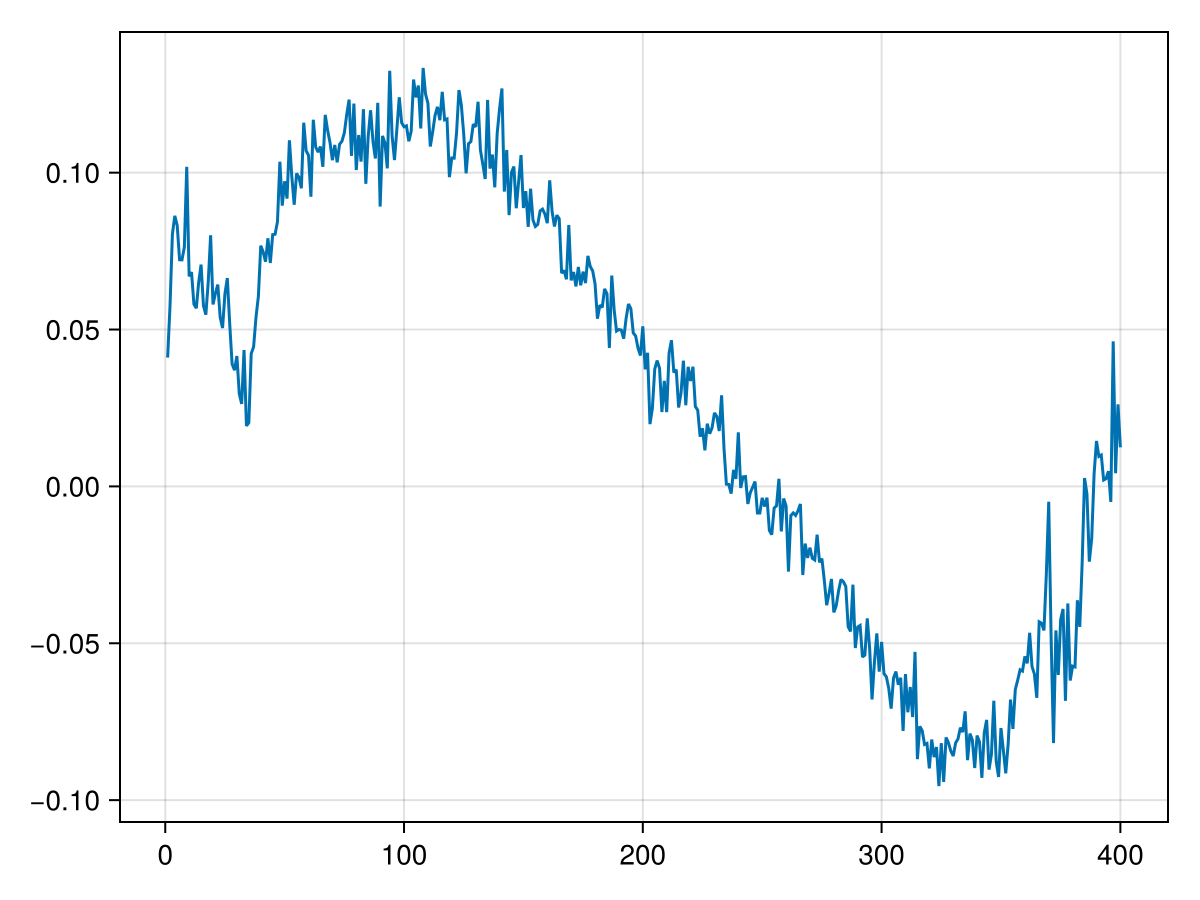

In [212]:
t_offset, _, _, u = load_snapshot(run_directory, 2)
lines((tau_params .- 1.25e-5 * (times .- t_offset)) ./ sum(tau_params) * length(tau_params))

In [215]:
1.25e-5 * t_offset

0.005126360702514649

In [214]:
sum(tau_params) / length(tau_params)

0.41169825076880395

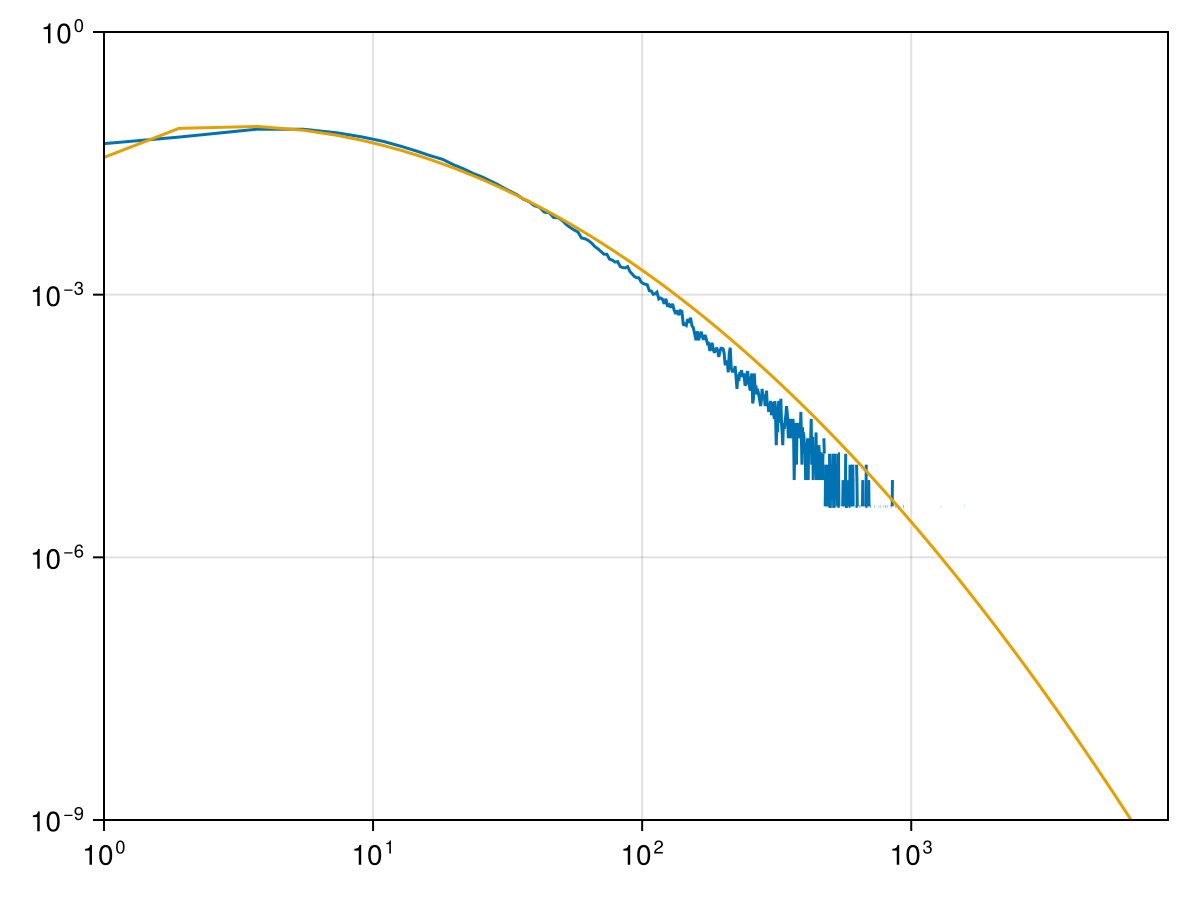

In [197]:
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((1, k_max), (1e-9, 1e0)))

lines!(ax, bin_centers, norm_bin_counts)
lines!(ax, bin_centers, exp.(theo_free_decay_spectrum(bin_centers, [1, fit.param[2]])))

fig

In [199]:
exp(fit.param[2])

0.8100817711068

In [210]:
function smoothing_function(x, N)
    moving_average_fn(i) = sum(@views(x[i-N:i+N]))/(2*N + 1)
    smooth_data = map(moving_average_fn, (N+1):(length(x)-N))
    return vcat(x[1:N], smooth_data, x[end-N+1:end])
end

smoothing_function (generic function with 1 method)

In [11]:
t_offset, _, _, u = load_snapshot(run_directory, 2)

bin_counts, time = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, Nsnapshots)
_, _, _, uf = load_snapshot(run_directory, Nsnapshots)
u_rms = sqrt.(sum(uf.^2)/Npackets)

Fr = u_rms / Cg

dissipated_fraction = sum(have_been_dissipated)/length(have_been_dissipated)

f = Figure(size=(1000, 600))
axis_options = (; xscale=log10, yscale=log10, xticks=([1e-1, 1e0, 1e1, 1e2, 1e3]), xlabel="ω/f0", limits=((1, 6e3), (1e-1, 5e4)))
Label(f[0,1:2], "Raytracing Energy spectra", fontsize=24)
ax_forced = Axis(f[1,2]; title=@sprintf("Forced-dissipative energy spectrum \r\n(Fr = %0.3f, cutoff=%0.2f/K_D, diss=%0.2f%%)", Fr, k_max/K_D, 100*dissipated_fraction), axis_options...)
ax_snap = Axis(f[1,1]; title=@sprintf("Freely-decaying energy spectrum \r\n(Fr = %0.3f, cutoff=%0.2f/f0)", Fr, ω_max/f0), axis_options...)

forced_action_spectrum = replace(forced_bin_counts, 0 => NaN) / Npackets ./ bin_size / total_snapshots
#forced_action_spectrum = replace(forced_bin_counts, 0 => NaN) / Npackets ./ bin_size# * (1e-3 / (1 + exp(-1e-3 * time)))
action_spectrum = replace(bin_counts, 0 => NaN) / Npackets ./ bin_size

#lin_action_spectrum = replace(lin_bin_counts, 0 => NaN) / total_snapshots / Npackets  / ((ω_max - ω_min) / Nbins)

radial_action_spectrum = action_spectrum
radial_forced_action_spectrum = forced_action_spectrum

k0 = 3
ω0 = compute_ω([k0;; 0], f0, Cg)[1]
k_max = sqrt(ω_max^2 - f0^2)/Cg
b0 = 0.0010277773867224367
b1 =   0.0006836805877861054
b_fd = 0.0006836805877861054
ks = @. sqrt(bin_centers^2 - f0^2)/Cg
conversion_factor = @. bin_centers / (Cg^2 * ks)

theo_action = theoretical_action_spectrum(ks, k0, k_max, b0, time - t_offset, f0, Cg)
theo_action[theo_action .<= 0] .= NaN
theo_action /= sum(theo_action)*bin_size

theo_fd_action = theoretical_forced_action_spectrum(ks, k0, k_max, b_fd, time - t_offset, f0, Cg) - theoretical_forced_action_spectrum(ks, k0, k_max, b_fd, 0, f0, Cg)
theo_fd_action[theo_fd_action .<= 0] .= NaN
theo_fd_action *=  0.33201494513479013 #/= sum(theo_fd_action)*bin_size

theo_action_unforced = theoretical_action_spectrum(ks, k0, k_max, b1, time - t_offset, f0, Cg)
theo_action_unforced[theo_action_unforced .<= 0] .= NaN
theo_action_unforced *= 1210.15582227743928#/= sum(theo_action_unforced) * bin_size

radial_energy = ωs .* radial_action_spectrum
radial_forced_energy = ωs .* radial_forced_action_spectrum

theo_energy = ωs .* theo_action .* conversion_factor
theo_fd_energy = ωs .* theo_fd_action .* conversion_factor
theo_unforced_energy = ωs .* theo_action_unforced .* conversion_factor

lines!(ax_snap, ωs/f0, radial_energy, color="blue", label="Energy spectrum")
lines!(ax_forced, ωs/f0, radial_forced_energy, color="red", label="Energy spectrum")

lines!(ax_snap, ωs/f0, theo_energy, color="black", linestyle=:dash, label="Theoretical spectrum")
lines!(ax_forced, ωs/f0, theo_fd_energy, color="black", linestyle=:dot, label="Theoretical spectrum")
#lines!(ax_forced, ωs/f0, theo_unforced_energy, color="black", linestyle=:dash, label="Theoretical freely-evolving spectrum")
#xx = bin_edges/f0
#lines!(ax, xx, 1.5e-5*xx.^(-0.3*log.(0.4*xx)), color="black", linestyle=:dash, label="Action spectrum (p(ω))")

axislegend(ax_snap, position=:lb)
axislegend(ax_forced, position=:lb)
colsize!(f.layout, 1, Aspect(1.0, 1))
colsize!(f.layout, 2, Aspect(1.0, 1))
resize_to_layout!(f)
f

LoadError: ArgumentError: file is closed

In [220]:
b1 * (time - t_offset)

13.33901687368321

In [49]:
using LsqFit

function find_best_b_fit(x, y, model, p0)
    fit = curve_fit(model, x, y, p0)
    return fit
end

theo_energy_spectrum(k, p) = log.(max.((f0^2 .+ Cg^2*k.^2) ./ (Cg^2 * k) .* p[1].*theoretical_action_spectrum(k, k0, k_max, max(p[2], 1e-19), time-t_offset, f0, Cg), 1e-19))
theo_fd_spectrum(k, p)     = p[1]*(theoretical_forced_action_spectrum(k, k0, k_max, max(p[2], 1e-19), time-t_offset, f0, Cg) - theoretical_forced_action_spectrum(k, k0, k_max, max(p[2], 1e-19), 0, f0, Cg))

nan_filter1 = @. ~isnan(radial_energy)
nan_filter2 = @. ~isnan(radial_forced_energy)

fit = find_best_b_fit(ks[nan_filter1], log.(radial_energy[nan_filter1]), theo_energy_spectrum, [10, 1e-6])
fit_fd = find_best_b_fit(ks[nan_filter2], radial_forced_action_spectrum[nan_filter2], theo_fd_spectrum, [0.1, 5e-4])
fit_fd_crazy = find_best_b_fit(ks[nan_filter2], log.(radial_forced_energy[nan_filter2]), theo_energy_spectrum, [1000, 1e-3])
#theo_action_spectrum(bin_centers, [1e-2])

println(fit.param)
println(fit.converged)
println(fit_fd.param)
println(fit_fd.converged)
println(fit_fd_crazy.param)
println(fit_fd_crazy.converged)

LoadError: UndefVarError: `radial_energy` not defined

In [194]:
ωs .* conversion_factor

5000-element Vector{Float64}:
   720.6233381985526
    13.944139379825673
    15.650877351751674
    18.361502979001013
    21.388407815455096
    24.562056322622166
    27.817333263611452
    31.12318077629306
    34.462705006885045
    37.825858731708216
    41.20626487056317
    44.59966913859629
    48.00311908822048
     ⋮
 17266.169964557546
 17269.63034881718
 17273.09073307697
 17276.551117336916
 17280.01150159701
 17283.471885857267
 17286.932270117675
 17290.39265437823
 17293.85303863895
 17297.31342289982
 17300.773807160844
 17304.234191422023

[3.1282207754579376e10, 0.0007307990156709139]


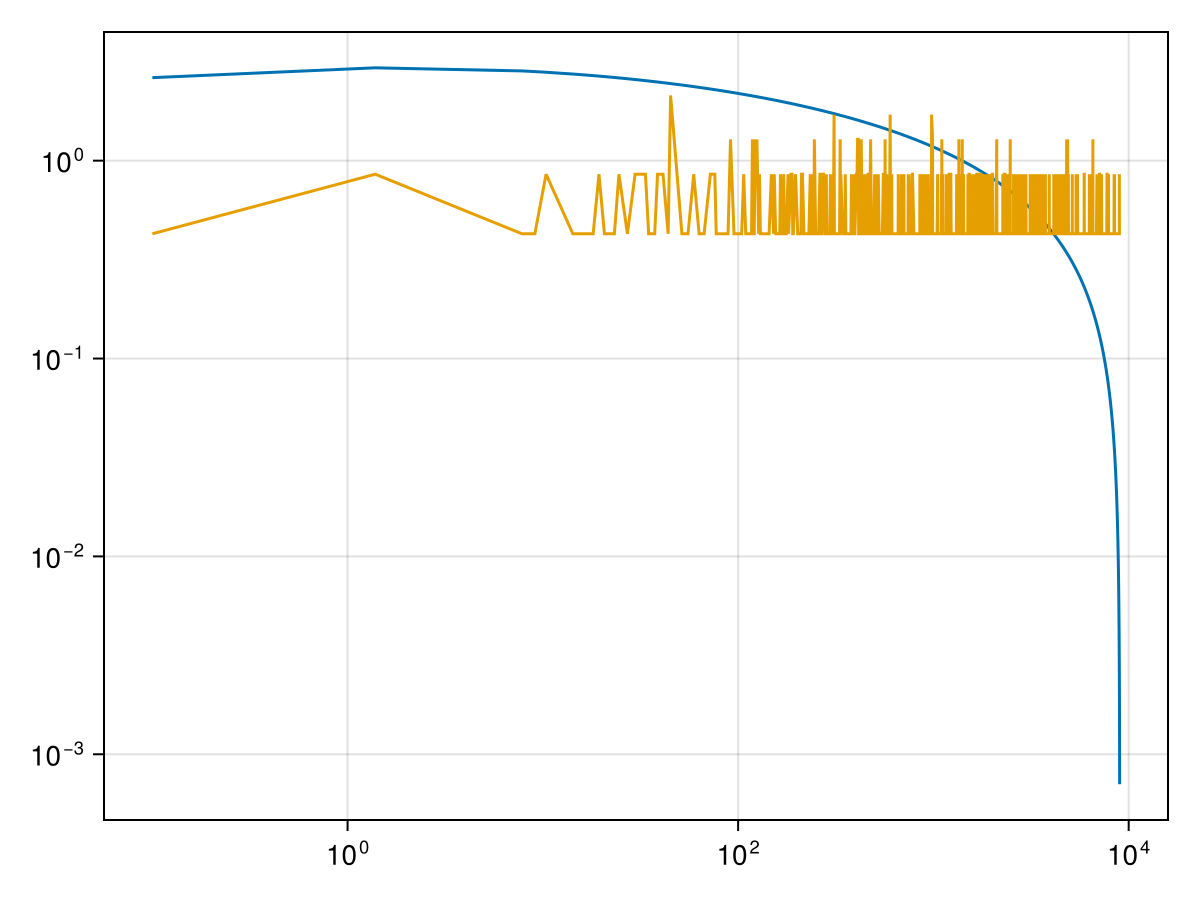

In [39]:
println(fit.param)
f1 = Figure()
ax = Axis(f1[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers[nan_filter1], exp.(theo_action_spectrum(bin_centers[nan_filter1], fit.param)))
lines!(ax, bin_centers[nan_filter1], radial_action_spectrum[nan_filter1])
f1

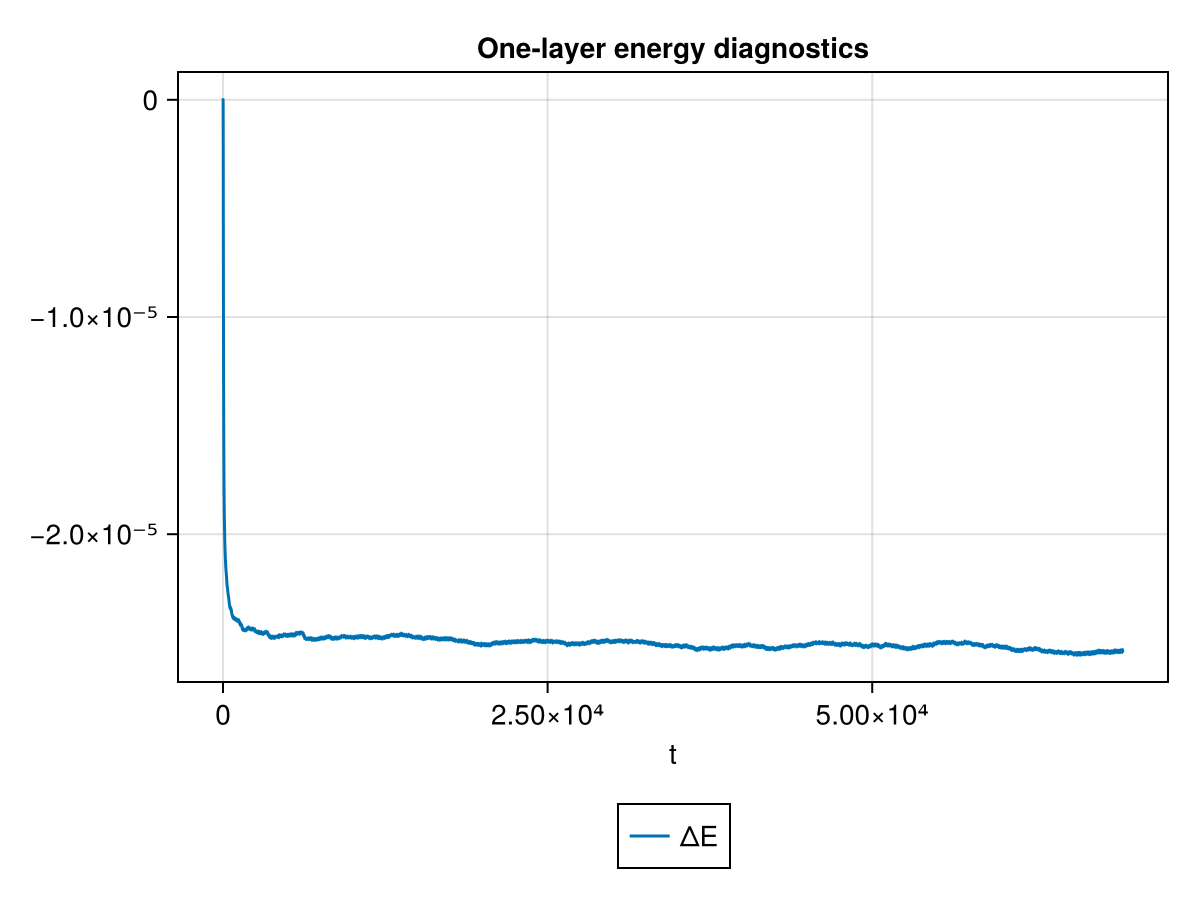

In [239]:
new_data_directory = "/scratch/nad9961/swqg/58628043/7/"
diag_file = jldopen(new_data_directory * "diagnostics.jld2")
t = diag_file["diagnostics/kinetic_energy/t"]
energy = diag_file["diagnostics/kinetic_energy/data"]
PE = diag_file["diagnostics/potential_energy/data"]
KE1 = map(x -> x, energy)
#KE2 = map(x -> x[2], energy)

fig = Figure()
ax = Axis(fig[1,1], xlabel="t", title="One-layer energy diagnostics")
lines!(ax, t, KE1 + PE .- KE1[1] .- PE[1], label="ΔE")
#lines!(ax, t, KE2, label="KE 2")
#lines!(ax, t, PE, label="PE")

Legend(fig[2,1], ax, orientation=:horizontal)
resize_to_layout!(fig)
fig

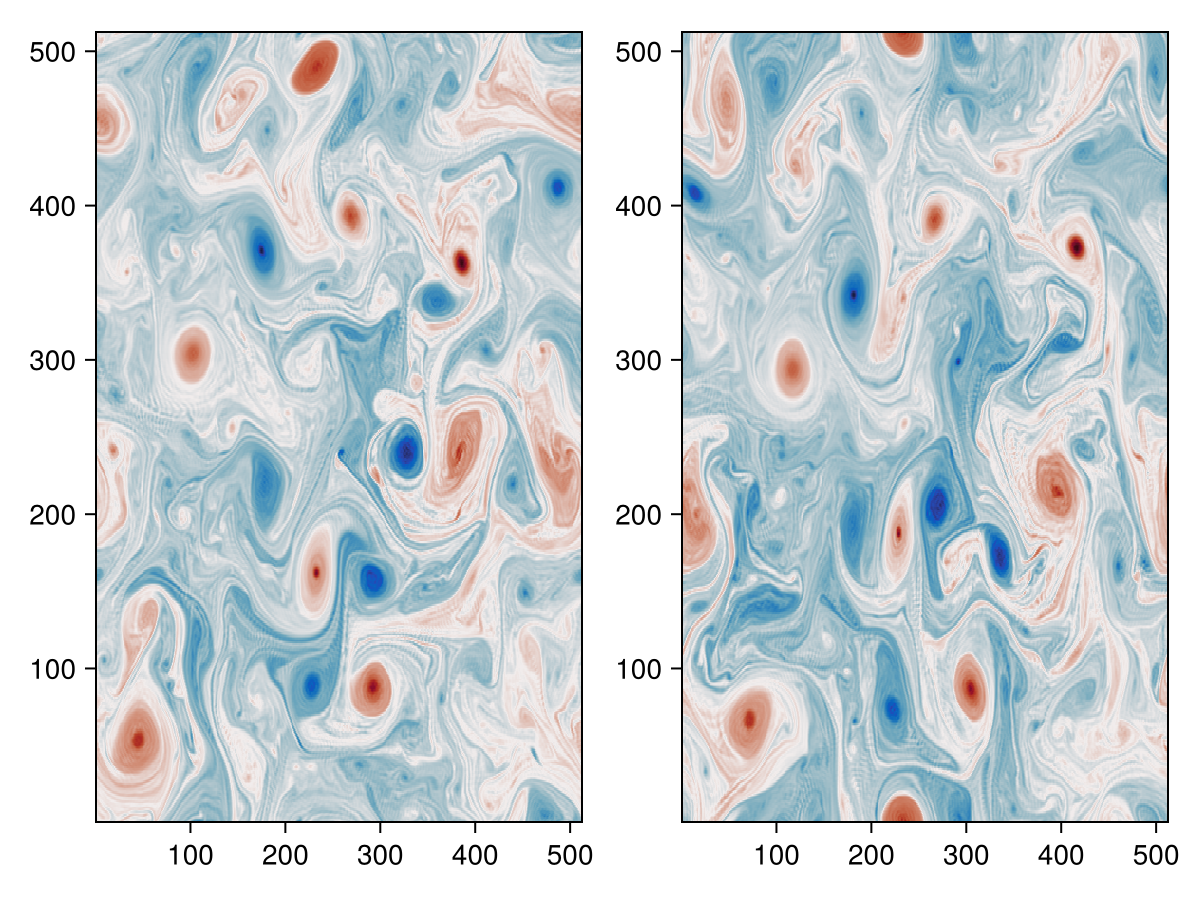

In [36]:
snapfile = jldopen(data_directory * "2Lqg.000001.jld2")
frames = keys(snapfile["snapshots/sol"])
sol1 = snapfile["snapshots/sol/" * frames[end-1]]
sol2 = snapfile["snapshots/sol/" * frames[end]]
using AbstractFFTs
q1 = irfft(sol1, 512, (1, 2))
q2 = irfft(sol2, 512, (1, 2))
fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
heatmap!(ax1, q1[:,:,1], colormap=:balance)
heatmap!(ax2, q2[:,:,1], colormap=:balance)

fig

In [28]:
println(fit.param)
println(fit_fd.param)
println(fit_fd_crazy.param)
time-t_offset

[3.3711871704979785e12, 0.0003903734286763114]
[0.03185585691942991, 4.341641378712992e-5]
[6.525575157637462, 0.00024161649915496882]


68903.375f0

In [10]:
f1 = Figure()
ax = Axis(f1[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers[nan_filter2], theo_fd_spectrum(bin_centers[nan_filter2], fit_fd.param))
lines!(ax, bin_centers[nan_filter2], radial_forced_action_spectrum[nan_filter2])
lines!(ax, bin_centers[nan_filter2], exp.(theo_action_spectrum(bin_centers[nan_filter2], fit_fd_crazy.param)))
f1

In [30]:
times = 0.01:0.1:15000
bin_counts = zeros(Nbins)
for ti=times
    bin_counts += theoretical_action_spectrum(bin_centers, k0, k_max, b, ti, f0, Cg) * 0.1
end

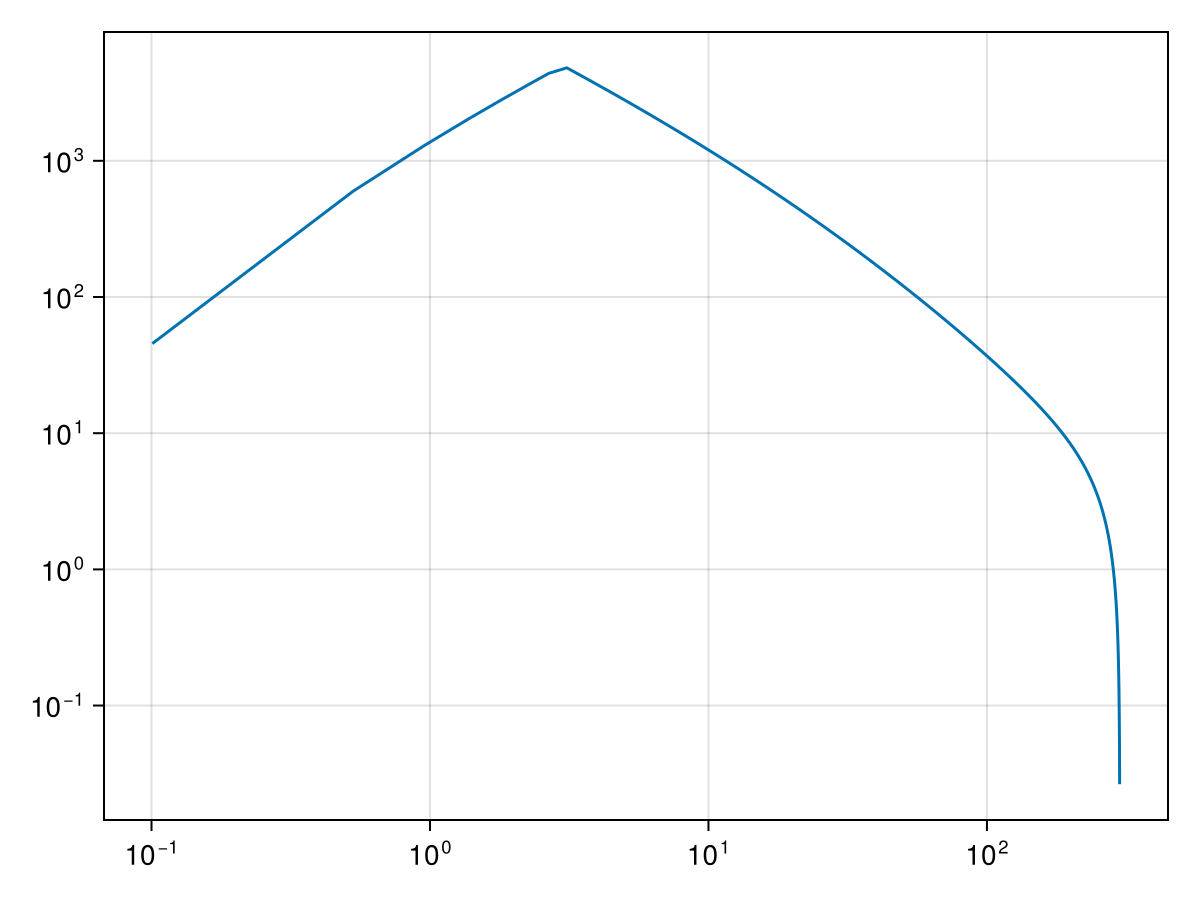

In [31]:
f = Figure()
ax = Axis(f[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers, bin_counts)
f

In [18]:
bin_counts1, time1 = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, Nsnapshots)
bin_counts2, time2 = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, Nsnapshots - 1)

([4144.0, 9610.0, 13005.0, 14542.0, 14732.0, 14077.0, 12978.0, 12197.0, 11039.0, 9968.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 64473.867f0)

In [28]:
t, x, k, u = load_snapshot(run_directory, 1)

(0.0f0, Float32[-3.1354568 -3.1354568; -3.123185 -3.1354568; … ; 3.123185 3.1354568; 3.1354568 3.1354568], Float32[3.0 7.190535f-5; 3.0 0.0001438107; … ; 3.0 -7.190535f-5; 3.0 -7.347881f-16], Float32[-0.023271836 0.010582042; -0.023692125 0.013761669; … ; -0.028951788 0.0032170946; -0.030256351 0.006468948])

In [29]:
k

262144×2 Matrix{Float32}:
 3.0   7.19053f-5
 3.0   0.000143811
 3.0   0.000215716
 3.0   0.000287621
 3.0   0.000359527
 3.0   0.000431432
 3.0   0.000503337
 3.0   0.000575243
 3.0   0.000647148
 3.0   0.000719053
 3.0   0.000790959
 3.0   0.000862864
 3.0   0.00093477
 ⋮    
 3.0  -0.000790959
 3.0  -0.000719053
 3.0  -0.000647148
 3.0  -0.000575243
 3.0  -0.000503337
 3.0  -0.000431432
 3.0  -0.000359527
 3.0  -0.000287621
 3.0  -0.000215716
 3.0  -0.000143811
 3.0  -7.19053f-5
 3.0  -7.34788f-16

In [21]:
new_data_directory = "/scratch/nad9961/swqg/59389740/7/"
Nsnaps = count_qgsw_snapshots(new_data_directory)
grid = TwoDGrid(; nx=512, Lx=2π)
t, q, ψ, u, v, Kd2 = load_qgsw_snapshot(new_data_directory, grid, 1000)

(10139.068f0, Float32[-0.026734328 -0.025126627 … -0.028728668 -0.028053064; -0.02651161 -0.024719425 … -0.02902092 -0.028068762; … ; -0.0268178 -0.02571701 … -0.027619604 -0.027526364; -0.026823936 -0.025463326 … -0.028243173 -0.027855264], [0.0015722372092663844 0.0015440702215446175 … 0.0016244821117698677 0.0015990948735599784; 0.0015905306469534359 0.0015627748545205345 … 0.0016420578586727862 0.0016170200323473308; … ; 0.0015339009119374677 0.0015049075447373557 … 0.0015876654627072534 0.0015615208772042331; 0.0015533617608752474 0.0015247873034370464 … 0.0016063424436226722 0.0015805911988115494], [0.0022444691626196753 0.002343314924067287 … 0.0020059677729487337 0.002130390924428592; 0.00221299889076966 0.0023075200436565163 … 0.001977524195898842 0.0021015118512787354; … ; 0.0023084615881329646 0.0024146270588559357 … 0.0020691300500208106 0.0021914609868934447; 0.00227587342096991 0.0023786170466858327 … 0.0020361170929100933 0.0021599636364483675], [0.001514290589008616 0.0

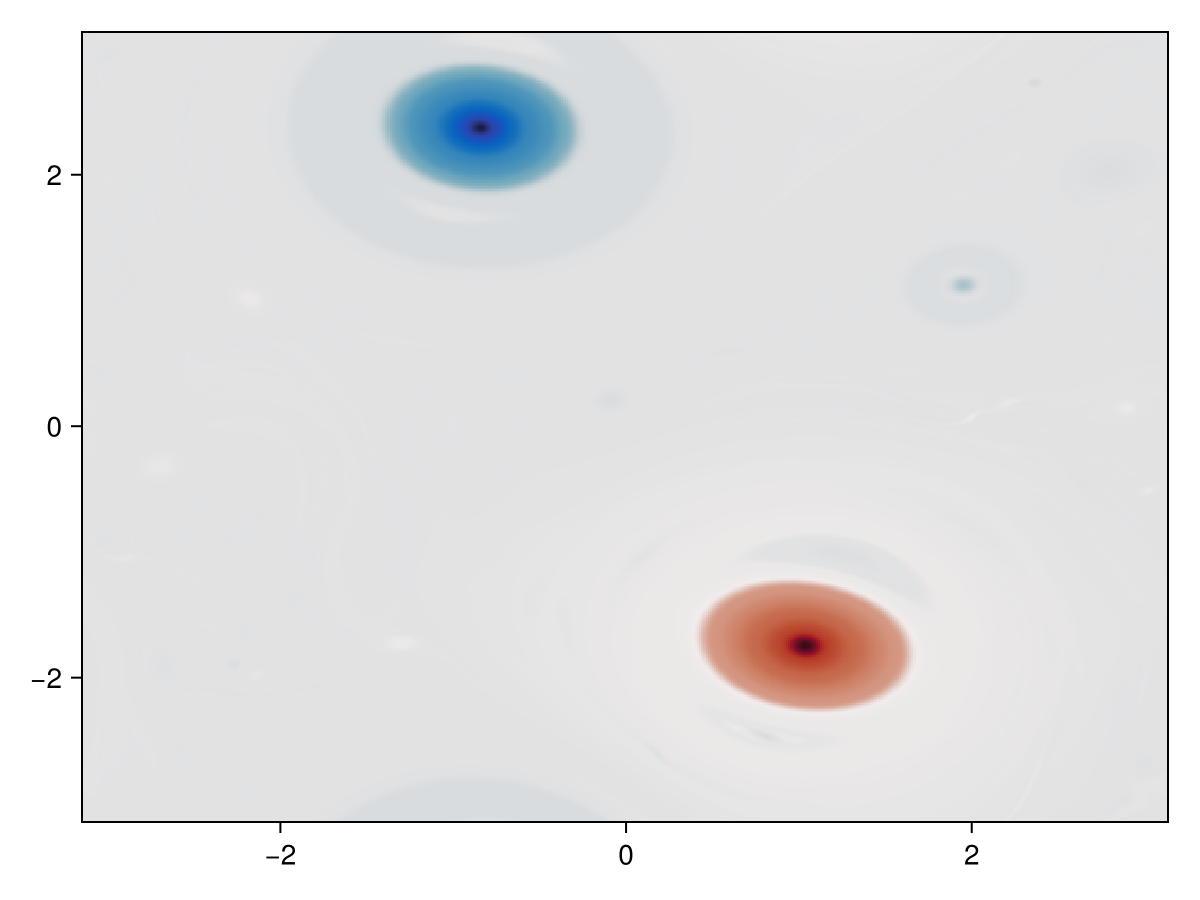

In [22]:
heatmap(grid.x, grid.y, q, colormap=:balance)

In [14]:
Nsnaps

6779